# How Many Transit Riders in California have Autos?

Questioner: Gillian Gillett  
March 23, 2022

## Setup Environment

! Warning: will install libraries into current environment.

In [1]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [100]:
try:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
except:
    logging.info('pandas seaborn not found. Will try and install into current environment')
    ! conda install pandas seaborn 
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

pd.set_option("display.max.columns", None)

In [3]:
import os
WORKING_DIR = os.path.dirname(os.getcwd())

logging.info(f"Working directory: {WORKING_DIR}")


INFO:root:Working directory: /Users/elizabeth/Documents/urbanlabs/CA_Interoperable/working/data-analyses


## National Household Travel Survey

Data Codebook: [https://nhts.ornl.gov/tables09/CodebookBrowser.aspx](https://nhts.ornl.gov/tables09/CodebookBrowser.aspx)

Relevant variables:

- HOUSEID	Household Identifier  
- HBHUR	Urban / Rural indicator - Block group  
- HHFAMINC	Household income  
- HHSIZE	Count of household members  
- HHSTATE	Household state
- HHVEHCNT	Count of Household vehicles
- WRKCOUNT	Number of workers in household
- WTHHFIN	Final HH weight

- CAR	Frequency of Personal Vehicle Use for Travel
- BUS	Frequency of Bus Use for Travel
- PARA	Frequency of Paratransit Use for Travel
- TAXI	Frequency of Taxi Service or Rideshare Use for Travel
- [WALK](https://nhts.ornl.gov/tables09/CodebookPage.aspx?id=1365) Frequency of Walk Use for Travel
- TRAIN	Frequency of Train Use for Travel

- PLACE	Travel is a Financial Burden
- PTRANS	Public Transportation to Reduce Financial Burden of Travel
- WALK2SAVE	Walk to Reduce Financial Burden of Travel

### Import Data

Assumes you have downloaded and unzipped NHTS data and weights into `csv` and `ReplicatesCSV` folders respectfully.

In [150]:
NHTS_DATA_DIR = os.path.join(os.path.dirname(WORKING_DIR), 'NHTS')
logging.info(f"NHTS Data directory: {NHTS_DATA_DIR}")

INFO:root:NHTS Data directory: /Users/elizabeth/Documents/urbanlabs/CA_Interoperable/working/NHTS


In [81]:
cols_to_keep = [
    'HOUSEID',
    'HHSIZE',
    'HHVEHCNT',
    'HHFAMINC',
    'BUS',
    'TRAIN',
    'WTHHFIN',
    'PLACE',
    'HHSTATE',
]

hh_all_df = pd.read_csv(
    os.path.join(NHTS_DATA_DIR, 'csv','hhpub.csv'),
    usecols=cols_to_keep,
)
hh_all_df = hh_all_df[hh_all_df['HHSTATE'] == 'CA']

hh_all_df.head()

,HOUSEID,HHSIZE,HHVEHCNT,HHFAMINC,BUS,TRAIN,PLACE,HHSTATE,WTHHFIN
6,30000041,2,2,11,4,4,5,CA,788.614240
9,30000085,1,2,9,5,5,3,CA,190.669041
11,30000094,1,1,4,5,5,2,CA,163.382292
19,30000155,1,2,-7,5,4,2,CA,120.772451
23,30000227,2,2,6,-9,-9,2,CA,62.015790


### Analyze NHTS Data

#### Recode Variables

In [130]:
def is_transit_user(x):
    _FREQ_TRANSIT = [1,2,3]
    _INFREQ_TRANSIT = [4,5]

    # UNKOWN
    if int(x['BUS']) < 0 or int(x['TRAIN']) < 0:
        return "Unknown"
    # NO
    if int(x['BUS']) == 5 and int(x['TRAIN']) == 5:
        return "No Transit Use"
    # YES
    if int(x['BUS']) in _FREQ_TRANSIT or int(x['TRAIN']) in _FREQ_TRANSIT:
        return "Frequent Transit"
    if int(x['BUS']) in _FREQ_TRANSIT+_INFREQ_TRANSIT or int(x['TRAIN']) in _FREQ_TRANSIT+_INFREQ_TRANSIT:
        return "Infrequent Transit"
    else:
        logging.debug(f"Unable to process row for is_transit_user:\n {x}")
        raise Exception(f'Unable to determine if transit user for row: {x}')

def has_hh_veh(x):
    # UNKOWN
    if int(x['HHVEHCNT']) < 0:
        return "Unknown"
    # NO
    if int(x['HHVEHCNT']) == 0:
        return "No Vehicle"
    # YES
    if int(x['HHVEHCNT']) > 0:
        return "Has vehicle"
    else:
        logging.debug(f"Unable to process row for has_hh_veh:\n {x}")
        raise Exception(f'Unable to determine if household has vehicles for row: {x}')

def travel_burden_hh(x):
    BURDEN = [1,2]
    NOT_BURDEN = [3,4,5]
    # UNKOWN
    if int(x['PLACE']) < 0:
        return "Unknown"
    # NO
    if int(x['PLACE']) in NOT_BURDEN:
        return "Not Burdened"
    # YES
    if int(x['PLACE']) in BURDEN:
        return "Burdened"
    else:
        logging.debug(f"Unable to process row for travel_burden_hh:\n {x}")
        raise Exception(f'Unable to determine if household has financial burden to travel for row: {x}')
        
def filter_recs(x):
    FILTER_COLS = ['transit_hh','vehicle_hh','burden_hh']
    FILTER_VALUE = "Unknown"
    if FILTER_VALUE in [x[c] for c in FILTER_COLS]:
        return -1
    return 1

In [131]:
analysis_cols = ['transit_hh','vehicle_hh','burden_hh']
hh_all_df['transit_hh'] = hh_all_df.apply(lambda x: is_transit_user(x), axis=1)
hh_all_df['vehicle_hh'] = hh_all_df.apply(lambda x: has_hh_veh(x), axis=1)
hh_all_df['burden_hh'] = hh_all_df.apply(lambda x: travel_burden_hh(x), axis=1)
hh_all_df['keep'] = hh_all_df.apply(lambda x: filter_recs(x) ,axis=1)

logging.debug(f"Excluded records:\n{hh_all_df[hh_all_df['keep']<0][analysis_cols].head()}")

hh_df = hh_all_df[hh_all_df['keep']>0]

for c in analysis_cols:
    hh_df[c]= pd.Categorical(
        hh_df[c],
        ordered = True,
    )
    
logging.debug(f"Cleaned records:\n{hh_df[analysis_cols].head()}")

recs_exc = len(hh_all_df)-len(hh_df)
logging.info(f"Cleaned records filtered to exclude {recs_exc}({round(100*recs_exc/len(hh_all_df),1)}%) of {len(hh_all_df)} records")
hh_all_df


DEBUG:root:Excluded records:
    transit_hh   vehicle_hh     burden_hh
23     Unknown  Has vehicle      Burdened
106    Unknown  Has vehicle       Unknown
141    Unknown  Has vehicle  Not Burdened
211    Unknown  Has vehicle       Unknown
221    Unknown  Has vehicle       Unknown
/var/folders/60/xd2kny110pxfz3ln611jq7hm0000gn/T/ipykernel_8795/143102953.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh_df[c]= pd.Categorical(
DEBUG:root:Cleaned records:
            transit_hh   vehicle_hh     burden_hh
6   Infrequent Transit  Has vehicle  Not Burdened
9       No Transit Use  Has vehicle  Not Burdened
11      No Transit Use  Has vehicle      Burdened
19  Infrequent Transit  Has vehicle      Burdened
37      No Transit Use  Has vehicle      Bur

,HOUSEID,HHSIZE,HHVEHCNT,HHFAMINC,BUS,TRAIN,PLACE,HHSTATE,WTHHFIN,transit_hh,vehicle_hh,burden_hh,keep
6,30000041,2,2,11,4,4,5,CA,788.614240,Infrequent Transit,Has vehicle,Not Burdened,1
9,30000085,1,2,9,5,5,3,CA,190.669041,No Transit Use,Has vehicle,Not Burdened,1
11,30000094,1,1,4,5,5,2,CA,163.382292,No Transit Use,Has vehicle,Burdened,1
19,30000155,1,2,-7,5,4,2,CA,120.772451,Infrequent Transit,Has vehicle,Burdened,1
23,30000227,2,2,6,-9,-9,2,CA,62.015790,Unknown,Has vehicle,Burdened,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129679,40794135,2,3,5,5,5,3,CA,63.217848,No Transit Use,Has vehicle,Not Burdened,1
129682,40794179,1,1,6,5,5,2,CA,377.126813,No Transit Use,Has vehicle,Burdened,1
129685,40794233,2,3,8,5,5,3,CA,33.421852,No Transit Use,Has vehicle,Not Burdened,1
129691,40794291,1,1,9,5,5,5,CA,41.869638,No Transit Use,Has vehicle,Not Burdened,1


In [194]:
hh_df_3way_ct = pd.crosstab(
    [hh_df['burden_hh'],hh_df['vehicle_hh']],
    hh_df['transit_hh'], 
    values = hh_df['WTHHFIN'], 
    aggfunc = sum,
    normalize='index',
    margins = True,
    rownames=['HHold Transportation Burden','HHold Vehicles'], 
    colnames=['HHold Transit Use in California (Source: NHTS 2017)'],
)
s_hh_df_3way_ct=hh_df_3way_ct.style\
    .background_gradient()\
    .format("{:.1%}")
    
s_hh_df_3way_ct

In [195]:
hh_df_ct = pd.crosstab(
    hh_df['vehicle_hh'],
    hh_df['transit_hh'], 
    values = hh_df['WTHHFIN'], 
    aggfunc = sum,
    normalize='index',
    margins = True,
    rownames=['HHold Vehicles'], 
    colnames=['HHold Transit Use in California (Source: NHTS 2017)'],
)
s_hh_df_ct=hh_df_ct.style\
    .background_gradient()\
    .format("{:.1%}")

s_hh_df_ct

HHold Transit Use in California (Source: NHTS 2017),Frequent Transit,Infrequent Transit,No Transit Use
HHold Vehicles,,,
Has vehicle,16.3%,32.3%,51.4%
No Vehicle,76.5%,8.5%,15.0%
All,20.3%,30.7%,49.0%


In [196]:
hh_df_ct_r = pd.crosstab(
    hh_df['transit_hh'], 
    hh_df['vehicle_hh'],
    values = hh_df['WTHHFIN'], 
    aggfunc = sum,
    normalize='index',
    margins = True,
    colnames=['HHold Vehicles'], 
    rownames=['HHold Transit Use in California (Source: NHTS 2017)'],
)
s_hh_df_ct_r=hh_df_ct_r.style\
    .background_gradient()\
    .format("{:.1%}")

s_hh_df_ct_r

HHold Vehicles,Has vehicle,No Vehicle
HHold Transit Use in California (Source: NHTS 2017),,
Frequent Transit,75.2%,24.8%
Infrequent Transit,98.2%,1.8%
No Transit Use,98.0%,2.0%
All,93.4%,6.6%


## Export Results

In [207]:
# Export to markdown

try: 
    import tabulate
except:
    !pip install tabulate
    
with open("results.md","w") as f:
    f.write("\n\n**Which transit-using households have vehicles?**\n\n")
    f.write(hh_df_ct.to_markdown(floatfmt=".1%"))
    f.write("\n\n**Which vehicle-owning households ride transit?**\n\n")
    f.write(hh_df_ct_r.to_markdown(floatfmt=".1%"))
    f.write("\n\n**Does it vary among households who are financially burdened by transportation?**\n\n")
    f.write(hh_df_3way_ct.to_markdown(floatfmt=".1%"))

In [209]:
## Exporting to images
try:
    import dataframe_image as dfi
except:
    ! pip install dataframe_image
    import dataframe_image as dfi

dfi.export(s_hh_df_ct,"hh_df_ct.png")
dfi.export(s_hh_df_ct_r,"hh_df_ct_r.png")
dfi.export(s_hh_df_3way_ct,"hh_df_3way_ct.png")

/Users/elizabeth/opt/miniconda3/envs/calitp/lib/python3.10/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0324/132220.507694:INFO:headless_shell.cc(659)] Written to file /var/folders/60/xd2kny110pxfz3ln611jq7hm0000gn/T/tmp2anbgsyh/temp.png.
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 295
DEBUG:PIL.PngImagePlugin:iCCP profile name b'Skia'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 348 8192
[0324/132222.411945:INFO:headless_shell.cc(659)] Written to file /var/folders/60/xd2kny110pxfz3ln611jq7hm0000gn/T/tmp3rt1v9vm/temp.png.
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 295
DEBUG:PIL.PngImagePlugin:iCCP profile name b'Skia'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 348 8192
[0324/132225.100427:I

In [113]:
# Plot Chord Chart
# Currently getting an error with this >:(

try:
    from chord import Chord
except:
    ! pip install chord
    from chord import Chord

names=list(hh_df_ct.columns)
matrix = hh_df_ct.values.tolist()
ch=Chord(hh_df_ct,names)

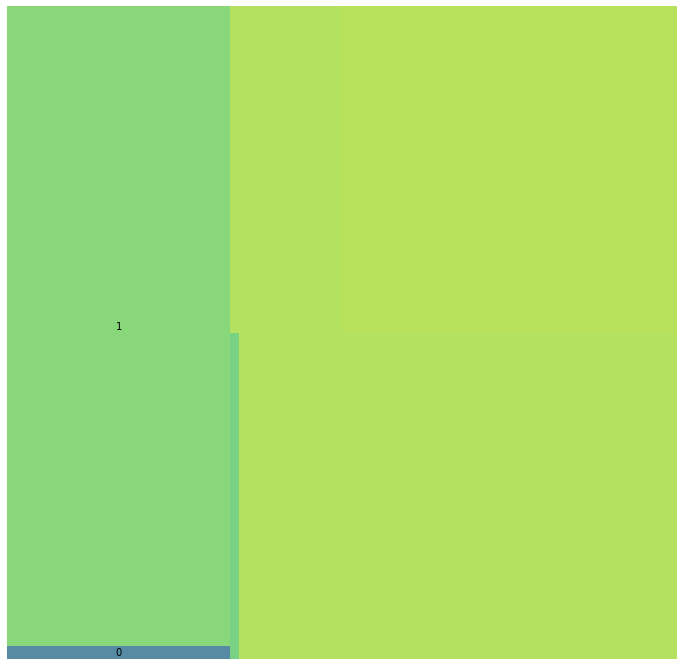

In [125]:
# Plot Tree Map
# This is really ugly >:(
try:
    import squarify 
except:
    ! pip install squarify 
    import squarify 

matrix = hh_df_ct.values.tolist()
values = [item for sublist in matrix for item in sublist]

names=list(hh_df_ct.columns)

fig, ax = plt.subplots(1, figsize = (12,12))
squarify.plot(sizes=values, 
              label=names, 
              alpha=.8 )
plt.axis('off')
plt.show()